In [1]:
import os
import pandas as pd
import geopandas as gpd
import numpy as np

# os.environ["USE_PYGEOS"] = os.environ.get("USE_PYGEOS", "0")
local_crs = 32636
# path to data
example_data_path = "./data"

c:\masterplanning\env\lib\site-packages\geopandas\_compat.py:124: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
C:\Users\skitl\AppData\Local\Temp\ipykernel_6656\3456685377.py:3: DeprecationWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas still uses PyGEOS by default. However, starting with version 0.14, the default will switch to Shapely. To force to use Shapely 2.0 now, you can either uninstall PyGEOS or set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In the next release, GeoPandas will switch to using Shapely by default, even if PyGEOS is installed. If you only have PyGEOS installed to get speed-ups, this switch should be smooth. However, if you are u

In [2]:
# load aggregated info we have
aggregated_blocks = gpd.read_parquet(os.path.join(example_data_path, "data_getter_blocks.parquet"))
accessibility_matrix = pd.read_pickle(os.path.join(example_data_path, "data_getter_matrix.pickle"))

In [3]:
# load data required for service graphs creation
schools = gpd.read_parquet(os.path.join(example_data_path, "schools.parquet"))
kindergartens = gpd.read_parquet(os.path.join(example_data_path, "kindergartens.parquet"))
recreational_areas = gpd.read_parquet(os.path.join(example_data_path, "recreational_areas.parquet")).rename_geometry('geometry')

hospitals = gpd.read_file(os.path.join(example_data_path, "hospitals.geojson"))
pharmacies = gpd.read_file(os.path.join(example_data_path, "pharmacies.geojson"))
policlinics = gpd.read_file(os.path.join(example_data_path, "policlinics.geojson"))

# services should be specified as a dictionary
services = {"schools": schools, "kindergartens": kindergartens, "recreational_areas": recreational_areas,
            "hospitals": hospitals, "pharmacies": pharmacies, "policlinics": policlinics}

In [4]:
from masterplan_tools import CityModel

city_model = CityModel(
  blocks=aggregated_blocks,
  accessibility_matrix=accessibility_matrix,
  services=services
)

c:\masterplanning\env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
from masterplan_tools import ProvisionModel

services_prov = {}

for service_type in city_model.get_service_types():
    provision = ProvisionModel(city_model=city_model, service_name=service_type)
    print(service_type)
    services_prov[service_type] = provision.run()

schools
kindergartens
recreational_areas
hospitals
pharmacies
policlinics


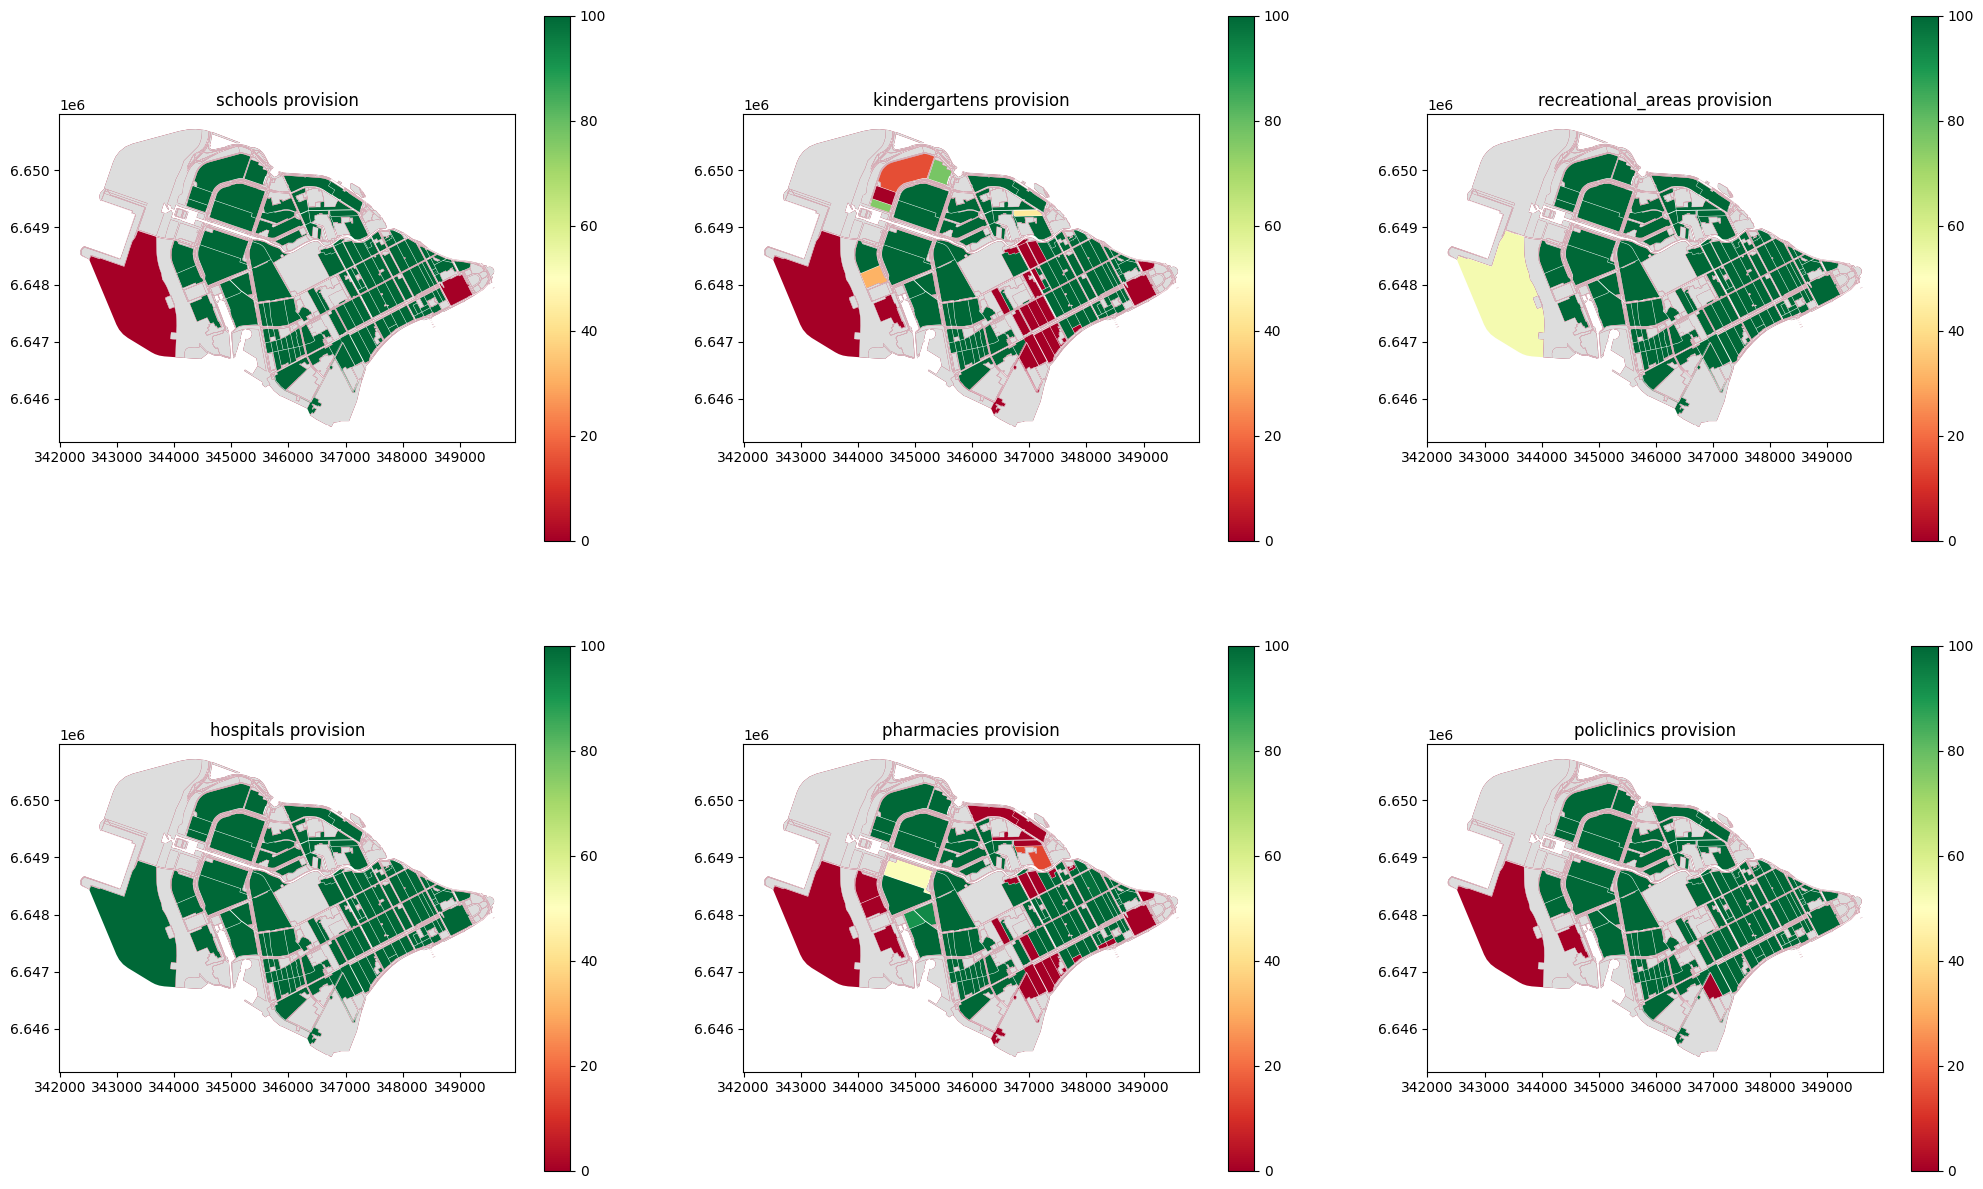

In [6]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

def show_me_chart(fig, gs, prov, name, i):
  ax = fig.add_subplot(gs[i//3, i%3])
  prov.plot(column="provision_"+name, legend=True, ax=ax, cmap='RdYlGn')
  ax.set_title(name +" provision")
  prov[prov["population"] == 0].plot(ax=ax, color="#ddd", alpha=1)


kindergartens_prov = services_prov["kindergartens"]
schools_prov = services_prov["schools"]
recreational_areas_prov = services_prov["recreational_areas"]
hospitals_prov = services_prov["hospitals"]
pharmacies_prov = services_prov["pharmacies"]
policlinics_prov = services_prov["policlinics"]

fig = plt.figure(figsize=(25, 15))
gs = GridSpec(2, 3, figure=fig)

i = 0
for service_type in services_prov:
  show_me_chart(fig, gs, services_prov[service_type], service_type, i)
  i = i+1

plt.show()

In [7]:
all_services = {
    'schools': {250: 1.2, 300: 1.1, 600: 1.3, 800: 1.5, 1100: 1.8},
    'kindergartens': {180: 0.72, 250: 1.44, 280: 1.1},
    'recreational_areas': {1000: 0.12},
    'pharmacies': {1000: 0.005},
    'hospitals': {500: 4, 1000: 8, 5000: 40, 10000: 80},
    'policlinics': {1000: 1.1, 3000: 3, 5000: 5},
    'random_key1': {123: 1.23, 456: 4.56},
    'random_key2': {234: 2.34, 345: 3.45}
}

scenario = ['hospitals', 'policlinics', 'recreational_areas', 'pharmacies']
weights = None
if not weights:
    weights = [round(1/len(scenario), 2) for i in range(len(scenario))]

scenario = dict(zip(scenario, weights))

In [8]:
scenario

{'hospitals': 0.25,
 'policlinics': 0.25,
 'recreational_areas': 0.25,
 'pharmacies': 0.25}

In [9]:
res = []
for k,v in scenario.items():
    res.append(v*((services_prov[k]['population_prov_' + k]/
    (services_prov[k]['population_prov_' + k] +
    services_prov[k]['population_unprov_' + k])).mean()))
sum(res)

0.938961638336993

In [10]:
res

[0.25, 0.244, 0.24907908713597207, 0.19588255120102097]

In [11]:
HECTARE_IN_SQUARE_METERS = 10_000


def read_df(services_prov):

    df = pd.concat([df.drop('geometry', axis=1) for df in services_prov.values()], axis=1)
    df = df.loc[:,~df.columns.duplicated()].copy()
    df['floors'].fillna(0, inplace=True)

    df[['area', 'current_living_area',
        'current_industrial_area', 'current_green_area']] = df[['area', 'current_living_area',
                                                                'current_industrial_area', 'current_green_area']]/HECTARE_IN_SQUARE_METERS
    df['free_area'] = df['area']*0.8 - df['current_green_area'] - df['current_industrial_area'] - df['current_living_area']

    return df


In [12]:
df = read_df(services_prov)
df.head()

,landuse,block_id,is_living,current_population,floors,current_living_area,current_green_capacity,current_green_area,current_parking_capacity,current_industrial_area,...,provision_hospitals,population_prov_hospitals,population_unprov_hospitals,provision_pharmacies,population_prov_pharmacies,population_unprov_pharmacies,provision_policlinics,population_prov_policlinics,population_unprov_policlinics,free_area
0,buildings,0,False,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0,0,0,0,0,0,0,0,0,0.003290
1,buildings,1,False,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0,0,0,0,0,0,0,0,0,0.012978
2,buildings,2,False,0.0,0.0,0.0,0.0,0.0,0.0,0.004264,...,0,0,0,0,0,0,0,0,0,-0.000372
3,buildings,3,False,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0,0,0,0,0,0,0,0,0,0.004919
4,buildings,4,False,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0,0,0,0,0,0,0,0,0,0.031183


In [24]:
upd = {}
for i, id in enumerate(df['block_id']):
    upd[i] = {'block_id': id, 'pharmacies_capacity': 500, 'is_pharmacies_service': 1}

In [26]:
graph_base = city_model.services_graph.copy()
graph = graph_base.copy()

for updated_block in upd.values():
    if updated_block['block_id'] in graph.nodes:
        for attr_name, attr_value in updated_block.items():
            if attr_name in graph.nodes[updated_block['block_id']]:
                graph.nodes[updated_block['block_id']][attr_name] += attr_value

city_model.services_graph = graph

services_prov = {}
for service_type in services.keys():
    provision = ProvisionModel(city_model=city_model, service_name=service_type)
    temp = provision.run()
    services_prov[service_type] = temp

city_model.services_graph = graph_base

In [28]:
res = []
for k,v in scenario.items():
    res.append(v*((services_prov[k]['population_prov_' + k]/
    (services_prov[k]['population_prov_' + k] +
    services_prov[k]['population_unprov_' + k])).mean()))
sum(res)

0.992220224651618

In [38]:
res

[0.25, 0.244, 0.24907908713597207, 0.20275590551181102]

In [22]:
city_model.services_graph = graph_base

In [66]:
df = read_df(services_prov)

In [67]:
df.shape

(1360, 31)

In [9]:
def flatten_dict(services, scenario):
    services_dict = {}
    for k,v in services.items():
        if k not in scenario:
            continue
        for kk,vv in v.items():
            services_dict[k+'_'+str(kk)] = vv
    services_df = pd.DataFrame([services_dict]).T
    return services_dict, services_df

In [10]:
import itertools

def combo(services_dict):
    comb = [list(itertools.combinations(list(services_dict.keys()), i)) for i in range(1, 4)]
    return [item for sublist in comb for item in sublist]


In [11]:
def df_update_variants(df, comb_weights):
    df['variants'] = df['free_area'].apply(lambda x: [i for i,com in enumerate(comb_weights) if com<=x])

In [52]:
res

[0.25, 0.244, 0.24671197269773562, 0.19588255120102097]

In [20]:
df = read_df(services_prov)
df = df[df['landuse']!='no_dev_area']

In [21]:
scenario_services = {k:v for k,v in services.items() if k in list(scenario.keys())}
services_dict, services_df = flatten_dict(scenario_services, list(scenario.keys()))

In [22]:
comb = combo(services_dict)

comb_w = []
for comb_ in comb:
    comb_w.append(services_df.loc[list(comb_)].sum()[0])

In [23]:
df_update_variants(df, comb_w)

In [24]:
df = df[df['variants'].apply(lambda x: len(x))!=0]

In [25]:
df.head()

,landuse,block_id,is_living,current_population,floors,current_living_area,current_green_capacity,current_green_area,current_parking_capacity,current_industrial_area,...,population_prov_hospitals,population_unprov_hospitals,provision_pharmacies,population_prov_pharmacies,population_unprov_pharmacies,provision_policlinics,population_prov_policlinics,population_unprov_policlinics,free_area,variants
1,buildings,1,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0.012978,[1]
4,buildings,4,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0.031183,[1]
6,buildings,6,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0.183895,"[0, 1, 9]"
7,buildings,7,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0.008738,[1]
9,buildings,9,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0.039372,[1]


In [26]:
total_vars = list(set([item for sublist in df['variants'].tolist() for item in sublist]))
variants = pd.DataFrame(columns=list(scenario.keys()), index=range(len(total_vars))).fillna(0)
for i,_ in enumerate(comb):
    for el in [x.rsplit('_', maxsplit=1) for x in _]:
        variants.loc[i, el[0]] += int(el[1])

In [62]:
blocks = np.zeros(df.shape[0])
blocks_for_change = np.random.randint(0, df.shape[0], 10)
change_variants = np.random.randint(0, variants.shape[0], 10)
blocks[blocks_for_change] = change_variants

In [63]:
ids = blocks.nonzero()[0]
vars_ = blocks[ids]
temp1 = df.iloc[ids][['block_id', 'population']].reset_index(drop=True)
temp2 = variants.iloc[vars_].reset_index(drop=True)

updated_blocks = pd.concat([temp1, temp2.add_suffix('_capacity')], axis=1).to_dict('index')

In [56]:
graph_base = city_model.services_graph.copy()

def fitness_func(ga_instance, blocks, solution_idx):
    ids = blocks.nonzero()[0]
    vars_ = blocks[ids]
    temp1 = df.iloc[ids][['block_id', 'population']].reset_index(drop=True)
    temp2 = variants.iloc[vars_].reset_index(drop=True)

    updated_blocks = pd.concat([temp1, temp2.add_suffix('_capacity')], axis=1).to_dict('index')

    graph = graph_base.copy()

    for updated_block in updated_blocks.values():
        if updated_block['block_id'] in graph.nodes:
            for attr_name, attr_value in updated_block.items():
                if attr_name in graph.nodes[updated_block['block_id']]:
                    graph.nodes[updated_block['block_id']][attr_name] += attr_value

    city_model.services_graph = graph

    services_prov = {}
    for service_type in list(scenario.keys()):
        provision = ProvisionModel(city_model=city_model, service_name=service_type)
        temp = provision.run()
        temp = temp[temp['population']!=0][['population_prov_' + service_type, 'population_unprov_' + service_type]]
        services_prov[service_type] = temp

    res = []
    for k,v in scenario.items():
        res.append(v*((services_prov[k]['population_prov_' + k]/
         (services_prov[k]['population_prov_' + k] +
          services_prov[k]['population_unprov_' + k])).mean()))

    fitness = sum(res)
    print(res)

    city_model.services_graph = graph_base

    return fitness

In [57]:
%%time
fitness_func(None, blocks, None)

[0.25, 0.244, 0.24674890499789254, 0.19392954729501316]
CPU times: total: 34.7 s
Wall time: 34.9 s


0.9346784522929057

In [58]:
blocks

array([  0.,  37.,   0.,   0.,   0.,   0.,  30.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,  34.,  13.,   0.,  34.,  44.,   0.,   0.,   0.,   0.,   0.,
        12.,   0.,   0.,   0.,  84.,   0., 101.,   0.,   0.,   0.,   0.,
         0.,   0.,  14.,   0.,   0.,   0.,  35.,   0., 104.,   0.,   0.,
         0.,   7.,   0.,   0.,  17.,   0., 107.,   0.,   0.,   0.,  93.,
         0.,  92.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0., 114.,   0., 102.,   0.,   0.,   0.,   0.,   0.,
        80.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  27.,
        80.,   0.,   0.,  24.,   0.,   0.,  33.,   1.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,  92.,  81.,   0.,   0.,   0.,  29.,   0.,   0.,
         0.,  45.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   6.,  38.,   

In [22]:
df['len_variants'] = df['variants'].apply(lambda x: len(x))

In [23]:
import pygad

In [24]:
ga_instance = pygad.GA(num_generations=3,
                       num_parents_mating=6,

                       fitness_func=fitness_func,

                       sol_per_pop=6,
                       num_genes=df[df['len_variants']!=0].reset_index(drop=True).shape[0],
                       gene_space=df[df['len_variants']!=0].reset_index(drop=True)['variants'].tolist(),
                       gene_type=int,

                       mutation_type='adaptive',
                       mutation_percent_genes=(90, 10),

                       # on_crossover = on_crossover,
                       crossover_type='scattered',

                       parent_selection_type='tournament',
                       K_tournament=3,

                       stop_criteria='saturate_50',
                       parallel_processing=12)

In [25]:
# ga_instance.plot_fitness()

In [ ]:
solution = ga_instance.best_solution()[0]

In [ ]:
updated_block_dict = {}

for i, block_id in enumerate(solution.nonzero()[0]):
    updated_block = {
        'block_id': df.loc[block_id]['block_id'],
        'population': df.loc[block_id]['population']}
    for k,v in variants.loc[solution[block_id]].to_dict().items():
        updated_block[k+'_capacity'] = v

    updated_block_dict[i] = updated_block